In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
import os
import sys

## Custom Imports

In [2]:
os.chdir("../fashion_ml")

In [86]:
from fashion_vae import FashionVAE
from data_loader import EZ_Dataloader
from experiment import FashionML

## Build Data Loader

In [4]:
dl = EZ_Dataloader("FashionMNIST")

In [5]:
dl.build_train_test_loader()

In [6]:
dl.build_val_loader()

## Build VAE

In [90]:
t = dl.train_loader.dataset

torch.Size([1, 28, 28])


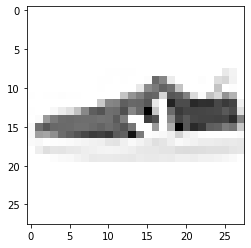

In [8]:
import matplotlib.pyplot as plt
a = t[12342][0]
print(a.shape)
plt.imshow(torch.squeeze(a), cmap = "Greys")

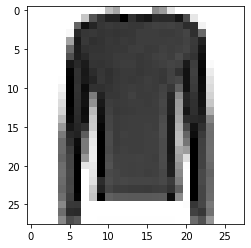

In [9]:
import matplotlib.pyplot as plt
b = t[999][0]
plt.imshow(torch.squeeze(b), cmap = "Greys")

In [87]:
fvae = FashionVAE(h_dims = [32,32,64], latent_dim = 2)

In [89]:
fvae.eval()
fvae.cuda()

FashionVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=3136, out_features=2, bias=True)
  (decoder_latent_space): Sequential(
    (0): Linear(in_features=2, out_features=3136, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=

In [8]:
fvae = fvae.cuda()
res = fvae.forward(torch.unsqueeze(a,0).cuda())

NameError: name 'a' is not defined

In [172]:
res[0].shape

torch.Size([1, 1, 28, 28])

In [173]:
adam = torch.optim.Adam

In [174]:
fml = FashionML(fvae, dl, adam)

In [175]:
fml.epochs = 100

In [85]:
#fml.fit()

In [93]:
fvae.load_state_dict(torch.load("../models/20_epoch_2ld_VAE_model.pt"))

<All keys matched successfully>

In [78]:
fvae = fvae.cuda()
latent, t = fvae.sample(1, include_locations= True)

print(latent)

tensor([[-0.1622,  2.3299]])


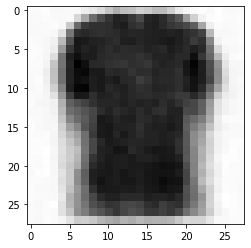

In [79]:
plt.imshow(torch.squeeze(t.detach().cpu()), cmap = "Greys")

In [52]:
import os
print(os.getcwd())

/home/showalte/classes/2020-21/Fall/CS273-Machine-Learning/CS273_Final_Project_VAE/fashion_ml


In [177]:
#torch.save(fml.model.state_dict(), "../models/100_epoch_2ld_VAE.pt")

In [85]:
img = []
for i in range(20):
    i1 = (i-10)/2
    row = []
    for j in range(20):
        i2 = (j-10)/2
        
        row.append(torch.squeeze(fvae.sample_latent((i1,i2))))
    
    img.append(torch.cat(row, axis = 1))

img = torch.cat(img, axis = 0)

In [86]:
img.shape

torch.Size([560, 560])

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

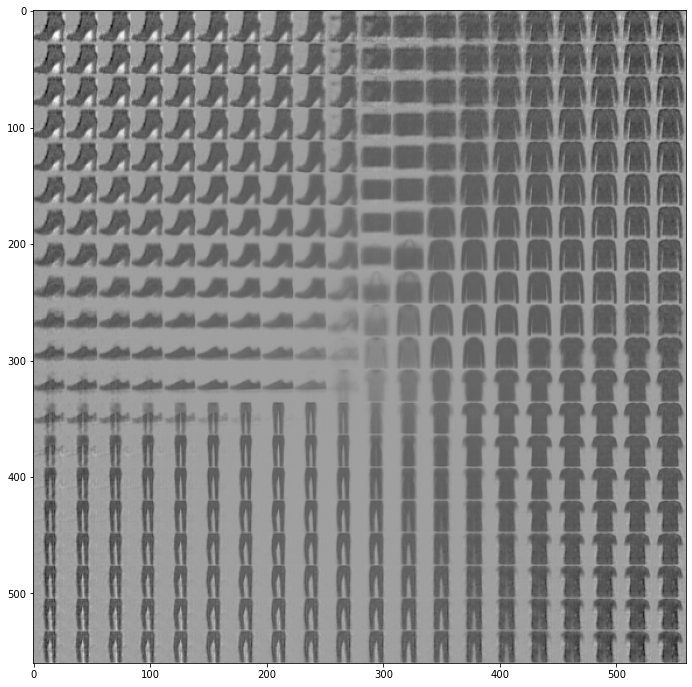

In [87]:
plt.figure(figsize = (12,12))
plt.imshow(img, cmap='Greys')
plt.axes("off")

In [105]:
a = torch.unsqueeze(t[50001][0],0)
b = torch.unsqueeze(t[2214][0],0)

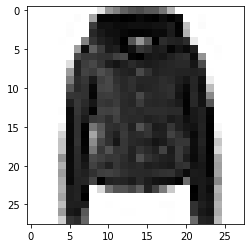

In [106]:
plt.imshow(torch.squeeze(a), cmap = 'Greys')

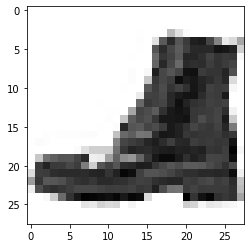

In [107]:
plt.imshow(torch.squeeze(b), cmap = 'Greys')

In [108]:
latent_reps = fvae.interpolate(a,b, num_samples = 10)

tensor([[-0.3395,  1.2878]], device='cuda:0')
tensor([[-0.4581,  1.0880]], device='cuda:0')
tensor([[-0.5767,  0.8883]], device='cuda:0')
tensor([[-0.6954,  0.6885]], device='cuda:0')
tensor([[-0.8140,  0.4888]], device='cuda:0')
tensor([[-0.9326,  0.2890]], device='cuda:0')
tensor([[-1.0512,  0.0893]], device='cuda:0')
tensor([[-1.1698, -0.1104]], device='cuda:0')
tensor([[-1.2884, -0.3102]], device='cuda:0')
tensor([[-1.4071, -0.5099]], device='cuda:0')


In [109]:
latent_reps[0].shape

torch.Size([1, 1, 28, 28])

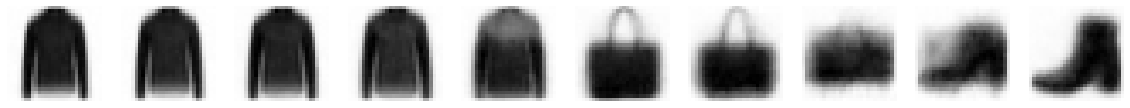

In [110]:
fig,axs = plt.subplots(1,len(latent_reps),figsize = (20,10))
for i in range(len(latent_reps)):
    axs[i].imshow(torch.squeeze(latent_reps[i]),cmap = "Greys")
    axs[i].axis("off")
plt.show()

In [120]:
r = fvae.forward(b.cuda())[0]

In [121]:
r.shape

torch.Size([1, 1, 28, 28])

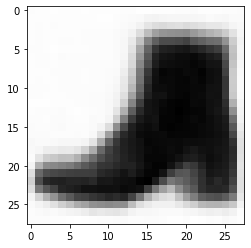

In [19]:
dataset = []; latent = []; label_info = []
for i, data in tqdm(enumerate(dl.test_loader, 0)):

    batch, labels = data 
    dataset.append(batch)
    label_info.append(labels)
    
    with torch.no_grad():
        mu, logvar = fvae.encode(batch.cuda())
        latent.append(fvae.reparameterize(mu, logvar).cpu())

In [20]:
raw = torch.cat(dataset, axis = 0)
latent_rep = torch.cat(latent, axis = 0)
print(raw.shape)
print(latent_rep.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 2])


In [21]:
labels = torch.cat(label_info, axis = 0)
labels.shape

torch.Size([10000])

In [149]:
data = torch.load("../data/FMNIST_Raw_Latent_Label/FashionMNIST_test_raw.pt")
latent = torch.load("../data/FMNIST_Raw_Latent_Label/FashionMNIST_test_latent.pt")
labels = torch.load("../data/FMNIST_Raw_Latent_Label/FashionMNIST_test_labels.pt")

In [127]:
label_dict = {0:	"T-shirt/top",
1:	"Trouser",
2:	"Pullover",
3:	"Dress",
4:	"Coat",
5:	"Sandal",
6:	"Shirt",
7:	"Sneaker",
8:	"Bag",
9:	"Ankle boot"}

In [128]:
import matplotlib.pyplot as plt
import random

Text(0.5, 1.0, '7417 Coat')

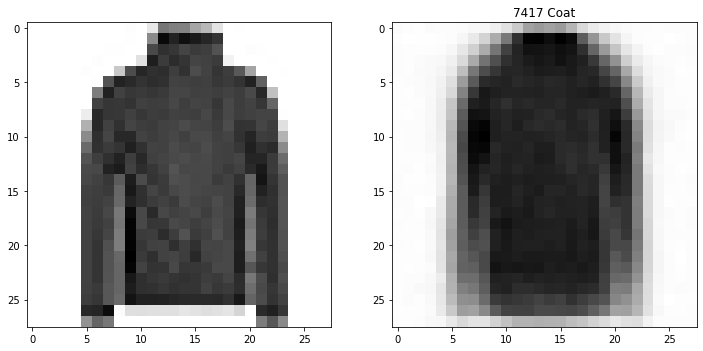

In [147]:
A = random.randint(0, data.shape[0])
fig, axs = plt.subplots(1,3,figsize = (12,12))
axs[0].imshow(torch.squeeze(data[A]), cmap = 'Greys')

with torch.no_grad():
    res = fvae.forward(torch.unsqueeze(data[A],0).cuda())[0]
    lres = fvae.
axs[1].imshow(torch.squeeze(res.cpu()), cmap = 'Greys')
axs[1].imshow(torch.squeeze(lres.cpu()), cmap = 'Greys')
plt.title(str(A) + " " + label_dict[labels[A].item()])